# IST 664 Final Project
### Kevin Harmer
This notebook was developed under the guidance of Lab 9 from the Syracuse iSchool's course IST 664. Model characteristics were also extracted from the Lab 10 of the same semester. While extracted from these labs, all code is directed toward the notebook's purpose. Also, I, Kevin Harmer, wrote all comments made in the code or in a surrounding text box to support project presentation.

## Introduction
The purpose of this project will be to write the first page of text in the style of Mark Twain. The text will be based off the two of Mark Twain's most popular novels: *Adventures of Huckleberry Finn* and *The Adventures of Tom Sawyer*. These online texts are available on gutenberg.org (exact links shown below and in references). The project is broken into several phases of development.

The first two sections of the project work with data processing. Section 1 works with the data to convert the unstructured data from gutenberg into organized text data for evaluation. The goal for this section is to organize data into vector notation, which is machine readable for the notebook's models. Section 2 takes the imported data and organizes it into squences and datasets that can be used for the neural network models. The data at this point is hard to recognized relative to its initial text form.

The third and fourth sections of the project concern model selection. In the development of a neural network model to write the final text, there are some analytics used to determine the best model. The third section deals with the development of three different neural networks: gated recurrent network, long short-term memory nework and a simple recurrent neural network. Once the models are developed, section 4 compares the three models, along with examining performance and accuracy among different epochs, embedding dimensions and neural network units.

Based on the results from section 4, section 5 works with the development and training of a final model. This step recognizes the strengths of models and their associated testing parameters and uses the best results in development. Once compiled and trained, this model is used in the writing of the new book.

Section 6 is dedicated to using the model from section 5 and generating it into text. The resulting neural network projects 2000 charcaters of text following the initial text of "Chapter 1", making it the first page of the computer-generated book.

Getting into the notebook, we start with uploading all the modules used in the process.

In [1]:
import tensorflow as tf #model module
from tensorflow import keras #layes of model development
from tensorflow.keras.layers.experimental import preprocessing #data processing

import numpy as np #numerical analysis
import time #cell timing
import matplotlib.pyplot as plt #used for model comparison

from urllib import request #reading in data from url

## 1. Importing and Manipulating the Data
Our first objective is obtaining the data. The following cells are used to import the text data from gutenberg.org.

*Adventures of Huckleberry Finn* Text Url: https://www.gutenberg.org/files/76/76-0.txt

*The Adventures of Tom Sawyer* Text Url: https://www.gutenberg.org/files/74/74-0.txt

In [2]:
hf_url = "https://www.gutenberg.org/files/76/76-0.txt" #huckleberry finn
hf_response = request.urlopen(hf_url)

ts_url = "https://www.gutenberg.org/files/74/74-0.txt" #tom sawyer
ts_response = request.urlopen(ts_url)

In [3]:
#reading in the huckleberry finn text file
hf_text = hf_response.read().decode('utf8') #entire huckleberry finn text
#len(hf_text) #len for text measurments
hf_text = hf_text[9572:] #removing all preliminary information up to chapter 1
#len(hf_text) #len for text measurments
hf_text = hf_text[:546355] #removing everything after the end of story; NEEDS TO BE AFTER INITIAL TEXT SPLIT
len(hf_text) #final huckleberry finn text length

546355

In [4]:
ts_text = ts_response.read().decode('utf8') #entire tom sawyer text
#len(ts_text) #len for text measurements
ts_text = ts_text[7997:] #removing all preliminary information up to chapter 1
#len(ts_text) #len for text measurements
ts_text = ts_text[:394264] #removing everything after end of story; NEEDS TO BE AFTER INITIAL TEXT SPLIT
len(ts_text) #final tom sawyer text length

394264

Once the data is imported, we start to convert it to machine readable data for analysis. The first step is organizing the characters of the text. These next few cells show the character analysis.

In [5]:
#Looking at input characters
hf_vocab = sorted(set(hf_text)) #Huckleberry Finn Characters
print("Huckleberry Finn has " + str(len(hf_vocab)) + " unique characters.")
ts_vocab = sorted(set(ts_text)) #Tom Sawyer Characters
print("\nTom Sawyer has " + str(len(ts_vocab)) + " unique characters.")

Huckleberry Finn has 77 unique characters.

Tom Sawyer has 74 unique characters.


In [6]:
#need to combine characters
vocab = sorted(set(list(set(hf_text))+list(set(ts_text)))) #combining unique lists of text characters into sorted unique set of total characters
print("In both texts combined, there are a total of " + str(len(vocab)) + " unique characters.")

In both texts combined, there are a total of 81 unique characters.


In [7]:
vocab[:10]

['\n', '\r', ' ', '!', '$', '&', "'", '(', ')', '*']

It is important that the final vocab character set has inputs from both texts. The resulting text at the end should have input that looks like the first two texts and that is only accomplished with all the possible characters. With character lists, we start to vectorize the input. Specifically, the characters are now broken into character id tensors. These contain all the ids with each character (for numeric representation) along with a '[UNK]' key, which represents characters not located in the texts.

In [8]:
#converting possible text inputs to vector layout with numerics for model analysis
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None) #ids from list of total vocab
ids_from_chars.get_vocabulary()[:10], len(ids_from_chars.get_vocabulary())

(['[UNK]', '\n', '\r', ' ', '!', '$', '&', "'", '(', ')'], 82)

In [9]:
#inversion function for ids; get characters from ids
chars_from_ids = preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

The preprocessed ids correspond to the correct characters from the book's combined vocab. They are identical other than '[UNK]', which represents a possible inputted unknown character. Now that our characters have been numerically described, we can convert the texts into these vectors.

In [10]:
hf_chars = tf.strings.unicode_split(hf_text, input_encoding='UTF-8') #encoding huckleberry finn into tensor
ts_chars = tf.strings.unicode_split(ts_text, input_encoding='UTF-8') #encoding tom sawyer into tensor
#hf_chars[:10] #taking a look at the first 10 characters in tensor form

In [11]:
hf_ids = ids_from_chars(hf_chars) #getting numeric ids from encoded tensor characters
ts_ids = ids_from_chars(ts_chars)
#hf_ids[:10] #previwing same ids from before

With our set of ids, we have efficiently gathered all of the characters into tensors. With that, we can move onto the next section.

## 2. Preparing Data for Model Training

At this point, it is necessary to start organizing in the data in a way that is machine readable, even if it is not human readable. Firstly, the texts are combined. This is because our objective is to write a new sequence regardless of the specific point in the story. Additionally, the text will be shuffled later, so the order does not completely matter.

In [12]:
tottext = hf_text + ts_text
num_char = len(tottext)

In [13]:
hf_id_dataset = tf.data.Dataset.from_tensor_slices(hf_ids)
ts_id_dataset = tf.data.Dataset.from_tensor_slices(ts_ids)

In [14]:
chars = tf.strings.unicode_split(tottext, input_encoding='UTF-8') #converting texts to tensor
ids = ids_from_chars(chars) #converting to ids based on tensor
id_dataset = tf.data.Dataset.from_tensor_slices(ids) #using dataset from tensorflow to organize data; will be elaborated later

With the combined text, we will now convert it to a set of sequences. These sequences will be analyzed individually. The models will be trained by these sequences and later generate similar sequences.

In [15]:
seq_length = 80 # 80 is about one line of standard text; 60 and 100 tested, but 80 led to best model
hf_sequences = hf_id_dataset.batch(seq_length+1, drop_remainder=True)
ts_sequences = ts_id_dataset.batch(seq_length+1, drop_remainder=True)
sequences = id_dataset.batch(seq_length+1, drop_remainder=True) #generating batchs of sequences with length designated above

The following block of code is taken from lab 9, with added original comments. The purpose of the code is to take the sequences and split them into a training set of sequences, then pair them with each of their following sequences. The result is then mapped into an entire data structure, which is labeled "dataset."

In [16]:
#following function taken from Lab 9
def split_input_target(sequence):
    input_text = sequence[:-1] #input text; initial sequences in data
    target_text = sequence[1:] #target text; exactly one sequence after input sequence
    return input_text, target_text

In [17]:
hf_dataset = hf_sequences.map(split_input_target)
ts_dataset = ts_sequences.map(split_input_target)
dataset = sequences.map(split_input_target) #developing data set with sequence to sequence pairs

Now that we have a data set of initial sequences to sequences immediately following the sequence, we can shuffle the sequences. This is important so that the dataset has some randomization of prediction to prevent overfitting.

In [18]:
batch_size = 64
hf_buffer = len(hf_text)
ts_buffer = len(ts_text)
buffer_size = len(tottext)

hf_dataset = dataset.shuffle(hf_buffer).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
ts_dataset = dataset.shuffle(ts_buffer).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
#dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

dataset = hf_dataset.concatenate(ts_dataset)

## 3. Building the Models

Now that the data has been prepared for models, we can move into the model development. Firstly, we define a few parameters:

In [19]:
vocab_size = len(chars_from_ids.get_vocabulary()) #number of unique characters
embedding_dim = len(chars_from_ids.get_vocabulary()) #number of embedding vector dimensions; possible overfitting when exceeding vocab size
rnn_units = 4*len(chars_from_ids.get_vocabulary()) #nodes for embedding layers (enough for 4 nodes)

The vocab size represents the amount of characters in the data set, the embedding dimension represents how in depth the embedding will be, and the rnn_units determine how many features the model can represent. In testing, embedding size was tested with twice the vocab_size and rnn_units was tested with anywhere from the embedding dimension to 20x the embedding dimension. The best results were embedding exactly at the vocab size and the rnn units about 10 times the size of the embedding dimension. The listed values, however, were used for model comparison.

Moving forwards, we will next build the actual models used for analysis. The following two models were developed using the models found in Lab 10.

In [20]:
class RNNmodel(tf.keras.Model): #School of Information Studies, 2022
  def __init__(self, vocab_size, embedding_dim, rnn_units, rnn_type = "RNN"):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #embedding tensorflow layer
    if rnn_type=="RNN": #run simple rnn; model 1
      #simple RNN model with returned sequences and states to grow from previous vaulues
      self.rnn = tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True,return_state=True)
    elif rnn_type == "GRU": #run GRU; model 2
      #GRU model with returned sequences and states to grow from previous vaulues
      self.rnn = tf.keras.layers.GRU(rnn_units,return_sequences=True,return_state=True)
    else:
      print("Type of Neural Network not Specificed. Please select 'RNN' or 'GRU'.")
    self.dense = tf.keras.layers.Dense(vocab_size) #bring the dimesions of internal layers back to the vocab size

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs #redfining alias
    x = self.embedding(x, training=training) #embedding the input baesd on training set
    if states is None:
      states = self.rnn.get_initial_state(x) #checking for initial states
    x, states = self.rnn(x, initial_state=states, training=training) #applying initial states if any
    x = self.dense(x, training=training) #applying to entire model
    if return_state: #checking return state
      return x, states
    else:
      return x

In [21]:
class LSTMmodel(keras.Model): #School of Information Studies, 2022
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #embedding layer
    self.rnn = tf.keras.layers.LSTM(rnn_units, return_sequences=True,return_state=True) #run LSTM; model 1
    self.dense = tf.keras.layers.Dense(vocab_size) #Dense Layer

  def call(self, inputs, states=None, return_state=False, training=False):
    #similar to other model
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.rnn.get_initial_state(x)
    x, states1, states2 = self.rnn(x, initial_state = states, training = training)
    x = self.dense(x, training=training)
    if return_state:
      return x, states1, states2
    else:
      return x

With defined models, we can move into the actual development of our models:

In [22]:
model1 = RNNmodel(vocab_size=vocab_size, #simple RNN model
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

model2 = RNNmodel(vocab_size=vocab_size, #GRU model
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    rnn_type = "GRU")

model3 = LSTMmodel(vocab_size=vocab_size, #LSTM model
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

# The following code is to help build the model; running the data set through
# an iteration of each model teaches the model what the input data will be.
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions1 = model1(input_example_batch)

for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions2 = model2(input_example_batch)

for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions3 = model3(input_example_batch)


Which lead to the model framework found in the following three cells:

In [23]:
model1.summary()

Model: "rn_nmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  6724      
                                                                 
 simple_rnn (SimpleRNN)      multiple                  134808    
                                                                 
 dense (Dense)               multiple                  26978     
                                                                 
Total params: 168,510
Trainable params: 168,510
Non-trainable params: 0
_________________________________________________________________


In [24]:
model2.summary()

Model: "rn_nmodel_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  6724      
                                                                 
 gru (GRU)                   multiple                  405408    
                                                                 
 dense_1 (Dense)             multiple                  26978     
                                                                 
Total params: 439,110
Trainable params: 439,110
Non-trainable params: 0
_________________________________________________________________


In [25]:
model3.summary()

Model: "lst_mmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  6724      
                                                                 
 lstm (LSTM)                 multiple                  539232    
                                                                 
 dense_2 (Dense)             multiple                  26978     
                                                                 
Total params: 572,934
Trainable params: 572,934
Non-trainable params: 0
_________________________________________________________________


## 4. Model Selection

Now that the framework of the models have been constructed, we can finally move into the data training and ultimately select a model. We begin by compiling each of the models using a crossentropy log loss function.

In [26]:
# setting the loss analysis
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model1.compile(optimizer='adam', loss=loss)
model2.compile(optimizer='adam', loss=loss)
model3.compile(optimizer='adam', loss=loss)

Then, we fit the following models. This is the step which requires the most parameter fluctuation. Parameters have been tuned and adjusted. The final parameters for display help the reader view the ultimate results of each model, leading to the model selection in the next section. *Note:* GPU Accelerator Recommended for this step.

In [27]:
history1 = model1.fit(dataset, epochs=20)
history2 = model2.fit(dataset, epochs=20)
history3 = model3.fit(dataset, epochs=20)

Epoch 1/20
105/105 [==============================] - 9s 72ms/step - loss: 2.9060
Epoch 2/20
105/105 [==============================] - 10s 89ms/step - loss: 2.2149
Epoch 3/20
105/105 [==============================] - 8s 72ms/step - loss: 2.0253
Epoch 4/20
105/105 [==============================] - 8s 73ms/step - loss: 1.9004
Epoch 5/20
105/105 [==============================] - 8s 70ms/step - loss: 1.8062
Epoch 6/20
105/105 [==============================] - 8s 71ms/step - loss: 1.7332
Epoch 7/20
105/105 [==============================] - 8s 72ms/step - loss: 1.6755
Epoch 8/20
105/105 [==============================] - 8s 72ms/step - loss: 1.6275
Epoch 9/20
105/105 [==============================] - 9s 81ms/step - loss: 1.5874
Epoch 10/20
105/105 [==============================] - 9s 74ms/step - loss: 1.5541
Epoch 11/20
105/105 [==============================] - 8s 73ms/step - loss: 1.5247
Epoch 12/20
105/105 [==============================] - 8s 72ms/step - loss: 1.5003
Epoch 13/20


Now that each of models have been trained, we can view their statistics. The GRU model ended in the lowest final loss, indicating that it may be the strongest model. As for performance, LSTM was the worst performing, and Simple RNN was the best performing, but the difference was not significant enough to exclude a model. Let's review the distribution of logit loss over per epoch.

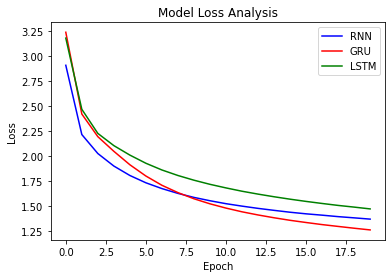

In [28]:
plt.figure()
plt.plot(history1.history["loss"], c = 'b', label='RNN')
plt.plot(history2.history["loss"], c = 'r', label='GRU')
plt.plot(history3.history["loss"], c = 'g', label='LSTM')
plt.title("Model Loss Analysis")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#initial observations favor Simple Reccurent Neural Network

After Epoch 5, the GRU model appeared to be the best performing model. GRU was also consistently the best over most the parameter training. Therefore, we will use a GRU variation model for the final result.

## 5. Compiling and Training Final Model

As discussed from in the previous cell, we will be using the GRU model which was analyzed previously. After parameter testing, the embedding dimension is best where it is at. RNN units, on the other hand, is best with 32 times the embedding dimension, or 32 nodes in the system. Increasing the rnn units decreased the loss until around 34. Furthermore, increasing the sequence length to 100 (increasing the amount of input per point), also decreased the loss, leading to that adjustment. With those values, the final model was was constructed, compiled, then trained. The results are shown below.

In [27]:
final_model = RNNmodel(vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=6*rnn_units, #8 times original rnn_units, leading to 32 times the embedding dimension
    rnn_type = "GRU") #GRU model result; now 32 rnn nodes

final_model.compile(optimizer='adam', loss=loss)
history = final_model.fit(dataset, epochs=15) #WARNING: may take long time to run

Epoch 1/15
362/362 [==============================] - 56s 127ms/step - loss: 2.3794
Epoch 2/15
362/362 [==============================] - 48s 129ms/step - loss: 1.6279
Epoch 3/15
362/362 [==============================] - 48s 129ms/step - loss: 1.3700
Epoch 4/15
362/362 [==============================] - 48s 129ms/step - loss: 1.2078
Epoch 5/15
362/362 [==============================] - 48s 129ms/step - loss: 1.0436
Epoch 6/15
362/362 [==============================] - 48s 130ms/step - loss: 0.8451
Epoch 7/15
362/362 [==============================] - 47s 126ms/step - loss: 0.6299
Epoch 8/15
362/362 [==============================] - 48s 130ms/step - loss: 0.4501
Epoch 9/15
362/362 [==============================] - 47s 126ms/step - loss: 0.3383
Epoch 10/15
362/362 [==============================] - 48s 129ms/step - loss: 0.2841
Epoch 11/15
362/362 [==============================] - 47s 128ms/step - loss: 0.2717
Epoch 12/15
362/362 [==============================] - 46s 125ms/step - lo

## 6. Generating Text From Model

Now that we have our model, which is designed to model the writing of Mark Twain, we can finally write our new Mark Twain book. The next set of code is derived from Lab 10 once again, with the purpose of predicting text based on the previous text.

In [31]:
class New(tf.keras.Model): #School of Information Studies, 2022
  def __init__(self, model, chars_from_ids, ids_from_chars, temp=1.0):
    super().__init__()
    self.temp = temp #scaling coefficient
    self.model = model #model used to produce text
    self.chars_from_ids = chars_from_ids #characters from indices input
    self.ids_from_chars = ids_from_chars #indices from characters input

    mask_ids = self.ids_from_chars(['[UNK]'])[:, None] #unknown character mask
    sparse_mask = tf.SparseTensor(values=[-float('inf')]*len(mask_ids), #all text before to current text
        indices=mask_ids, #current text
        dense_shape=[len(ids_from_chars.get_vocabulary())]) #shape of matrix given vocab size
    self.prediction_mask = tf.sparse.to_dense(sparse_mask) #tf mask

  @tf.function
  def generate_one_step(self, inputs, states=None):
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8') #input text to convert to characters
    input_ids = self.ids_from_chars(input_chars).to_tensor() #getting characters and converting to ids

    pred_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True) #logit predictions

    pred_logits = pred_logits[:, -1, :] #using most recent prediction
    pred_logits = pred_logits/self.temp #scaling prediction

    pred_logits = pred_logits + self.prediction_mask #masking term

    pred_ids = tf.random.categorical(pred_logits, num_samples=1) #generating predicted ids
    pred_ids = tf.squeeze(pred_ids, axis=-1)
    pred_chars = self.chars_from_ids(pred_ids) #returning to characters
    
    return pred_chars, states #returning text and state

Now that the model is compiled, we can incorporate the trained model and run it with our data. The temperature is adjusted based on the desired randomness in the data. Observationally, 1.0 appeared to have the best writen result

In [32]:
newbook = New(final_model, chars_from_ids, ids_from_chars, temp = 1.0)

Now that text generation model is complete, we can start viewing text from the new book! The first 2000 characters are shown below.

In [33]:
states = None
next_char = tf.constant(["\r\n\r\n\r\nCHAPTER I.\r\n\r\n\r\n"])
result = [next_char] #starting with "Chapter I."

for n in range(2000): #first 200 characters; about first page
  next_char, states = newbook.generate_one_step(next_char, states=states) #gnerating the next step of text from the initial (to end)
  result.append(next_char) #appending result into text

result = tf.strings.join(result) #joining all of the resulting strings
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80) #printing the results




CHAPTER I.


A bringing stared and chap, and a snake-skinned nothing. “The whole fight now! I won’t betry and tell you what's
going on they every day if they get back to the widow’s baggles. That’ll be a good boy.”

Says If get me worse. After with her ifas' hands considered a miserab endures wishing him and A
new-caustry and snoress as they walled; and told me to come back. This well night. They gained on the
ferry landing, and there was no window was upter some conspicuous eight now ex to tell on it. It set down in
dewn he would slip over all this outfroken search would be in a man on the tribe of Grangerfords, and frocks entirely.

But Stands for the family would say their pipes and powerful jacter. The old lady seas it was a good name and scratched out a
pie and the hat church. He said I wished I was glad I hadn't fell day. Con you going
to camp from grought on the table end of the floor and old rat he older
up any more--both or our house; and if you're abroading a pipon without

## Conclusion
Once the text is generated, our objective is complete! Several coherent paragraphs of text are exactly what we are looking for. Overall, the book appears to be in good shape relative to the training methods. Although it is not perfect grammatically, the text does appear to be written with an underlying plot and purpose. Although it may seem confusing at first glance, Mark Twain himself was not always the clearest in his writing; the test does appear to resemble him partially.

So, the output was successful in the objective. Along with coherent sentences, sentences and paragraphs seem to be somewhat related. But how can it be better or include a larger plotline with Huckleberry Finn and Tom Sawyer? Running the model with a larger data set of books or increasing the memory layers would likely decrease the loss, thus supporting the overall quality of the text. Specifically, if the model trained with more books written by Mark Twain about the two main characters would surely improve the models. Furthermore, adding additional layers to the models would likely improve the memories linking the text much more efficiently. Also, generating more text, in general, may help the plot develop as well. The text seems to be from Huckleberry Finn's perspective and mentions Tom in the text as well (may change based on run instance).

Expanding this concept, this method could surely be used for other authors. Moving forward, the model structure could be documented then incorporated into some designated function. This function could take in text data, train it with its variations, then return new similar text. Using other authors and other books, especially those from gutenberg, may help with the development of new stories.

## References
- School of Infomation Studies. (2022, Spring). IST 664 Lab 9 Notebook. Syracuse, New York: Syracuse University. Retrieved from class website at https://blackboard.syracuse.edu/bbcswebdav/pid-7942130-dt-content-rid-88619002_1/xid-88619002_1.
- School of Infomation Studies. (2022, Spring). IST 664 Lab 10 Notebook. Syracuse, New York: Syracuse University. Retrieved from class website at https://blackboard.syracuse.edu/bbcswebdav/pid-7954325-dt-content-rid-88999200_1/xid-88999200_1.